<a href="https://colab.research.google.com/github/nguyenhaidang94/TomatoDiseaseDetection/blob/master/Tomato_Disease_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import requests
import zipfile
import pathlib
import IPython.display as display
import random
import numpy as np

import tensorflow as tf
import cv2
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import adamax


from matplotlib import pyplot as plt

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
dest_folder = '/content/drive/My Drive/Colab Notebooks/TomatoDiseaseDetection'

## Download file

In [0]:
url = 'https://codeload.github.com/spMohanty/PlantVillage-Dataset/zip/master'
file_name = 'plant_village.zip'

print('Downloading...')
# r = requests.get(url, allow_redirects=True)
# open(dest_folder + file_name, 'wb').write(r.content)
print('Finish!')

Downloading...
Finish!


## Unzip

In [0]:
def extract_folder(archi, folder_path, dest_folder):
  print('Folder:', folder_path)
  count = 0
  print('Processing...')
  for file in archi.namelist():
    if file.startswith(folder_path):
      archi.extract(file, dest_folder)
      count += 1
  print('Finish extracting', count, 'files')

In [0]:
segment_path = 'PlantVillage-Dataset-master/raw/segmented'
folders = [
    'Tomato___Bacterial_spot',
    'Tomato___Early_blight',
    'Tomato___Late_blight',
    'Tomato___Leaf_Mold',
    'Tomato___Septoria_leaf_spot',
    'Tomato___Spider_mites Two-spotted_spider_mite',
    'Tomato___Target_Spot',
    'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
    'Tomato___Tomato_mosaic_virus',
    'Tomato___healthy'
]

# archive = zipfile.ZipFile(dest_folder +'/'+ file_name, 'r')
# for folder in folders:
#   extract_folder(archive, segment_path+'/'+ folder, dest_folder)
# archive.close()

## Load images and save dataset

In [0]:
def load_data(folder_path, label, img_size):
  count = 0
  data = []
  data_root = pathlib.Path(folder_path)
  all_img_paths = list(data_root.glob('*'))
  all_img_paths = [str(path) for path in all_img_paths]
  
  for img_path in all_img_paths:
    bgr_img = cv2.imread(str(img_path))
    bgr_img = cv2.resize(bgr_img, img_size)
    rgb_img = bgr_img[...,::-1]/255.0
    data.append(rgb_img)

  img_count = len(all_img_paths)
  labels = [label] * img_count
  labels = np.reshape(labels, (img_count, 1))
  return data, labels

In [0]:
segmented_path = '/content/drive/My Drive/Colab Notebooks/TomatoDiseaseDetection/PlantVillage-Dataset-master/raw/segmented'
locations = [
    segmented_path + '/Tomato___Bacterial_spot',
    segmented_path + '/Tomato___Late_blight'
]
labels = [0, 1]
img_row_size = 128
img_cln_size = 128
channel = 3

X = np.empty((0, img_row_size, img_cln_size, channel))
y = np.empty((0, 1))

print('Processing...')
for i in range(0, len(locations)):
  data, lbls = load_data(locations[i], labels[i], (img_row_size, img_cln_size))
  X = np.concatenate((X, data))
  y = np.concatenate((y, lbls))
print('Finish!')

Processing...
Finish!


In [0]:
data_file = 'data'
label_file = 'labels'

np.save(dest_folder +'/'+ data_file, X)
np.save(dest_folder +'/'+ label_file, y)

## Load dataset for train

In [0]:
data_file = 'data.npy'
label_file = 'labels.npy'

In [0]:
X = np.load(dest_folder +'/'+ data_file)
y = np.load(dest_folder +'/'+ label_file)
print(np.shape(X))
print(np.shape(y))

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1994, shuffle=True)

In [0]:
print("Train samples:", X_train.shape, y_train.shape)
print("Test samples:", X_test.shape, y_test.shape)

Train samples: (2825, 128, 128, 3) (2825, 1)
Test samples: (1211, 128, 128, 3) (1211, 1)


In [0]:
num_classes = 2
y_train_1hot = to_categorical(y_train, num_classes)
y_test_1hot = to_categorical(y_test, num_classes)

## Define CNN Architecture

In [0]:
def make_model():
  model = Sequential()
  
  model.add(Conv2D(32, (3, 3), padding='same', input_shape=X_train.shape[1:]))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.3))

  model.add(Conv2D(64, (3, 3), padding='same', input_shape=X_train.shape[1:]))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.3))

  model.add(Conv2D(128, (3, 3), padding='same', input_shape=X_train.shape[1:]))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.4))

  model.add(Flatten())
  model.add(Dense(80))
  model.add(Activation('relu'))
  model.add(Dropout(0.3))
  model.add(Dense(num_classes))
  model.add(Activation('softmax'))
  
  return model

## Train model

In [0]:
INIT_LR = 5e-3  # initial learning rate
BATCH_SIZE = 64
EPOCHS = 10
labels = ['Bacterial spot', 'Late blight']

In [0]:
model = make_model()  # define our model
opt = adamax(lr=INIT_LR)

# prepare model for fitting (loss, optimizer, etc)
model.compile(
    loss='categorical_crossentropy',  # we train 10-way classification
    optimizer=opt,
    metrics=['accuracy']  # report accuracy during training
)

In [0]:
# fit model
model.fit(
    X_train, y_train_1hot,  # prepared data
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_test, y_test_1hot),
    shuffle=True
)

Instructions for updating:
Use tf.cast instead.
Train on 2825 samples, validate on 1211 samples
Epoch 1/10
2825/2825 [==============================] - 11s 4ms/step - loss: 0.6497 - acc: 0.7982 - val_loss: 0.2954 - val_acc: 0.8753
Epoch 2/10
2825/2825 [==============================] - 5s 2ms/step - loss: 0.2481 - acc: 0.9094 - val_loss: 0.2335 - val_acc: 0.9273
Epoch 3/10
2825/2825 [==============================] - 5s 2ms/step - loss: 0.2026 - acc: 0.9214 - val_loss: 0.1991 - val_acc: 0.9224
Epoch 4/10
2825/2825 [==============================] - 5s 2ms/step - loss: 0.1619 - acc: 0.9377 - val_loss: 0.1558 - val_acc: 0.9447
Epoch 5/10
2825/2825 [==============================] - 5s 2ms/step - loss: 0.1484 - acc: 0.9441 - val_loss: 0.1691 - val_acc: 0.9414
Epoch 6/10
2825/2825 [==============================] - 5s 2ms/step - loss: 0.1126 - acc: 0.9558 - val_loss: 0.1333 - val_acc: 0.9496
Epoch 7/10
2825/2825 [==============================] - 5s 2ms/step - loss: 0.1163 - acc: 0.9589 - 

In [0]:
# make test predictions
y_pred_test = model.predict_proba(X_test)
y_pred_test_classes = np.argmax(y_pred_test, axis=1)
y_pred_test_max_probas = np.max(y_pred_test, axis=1)

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


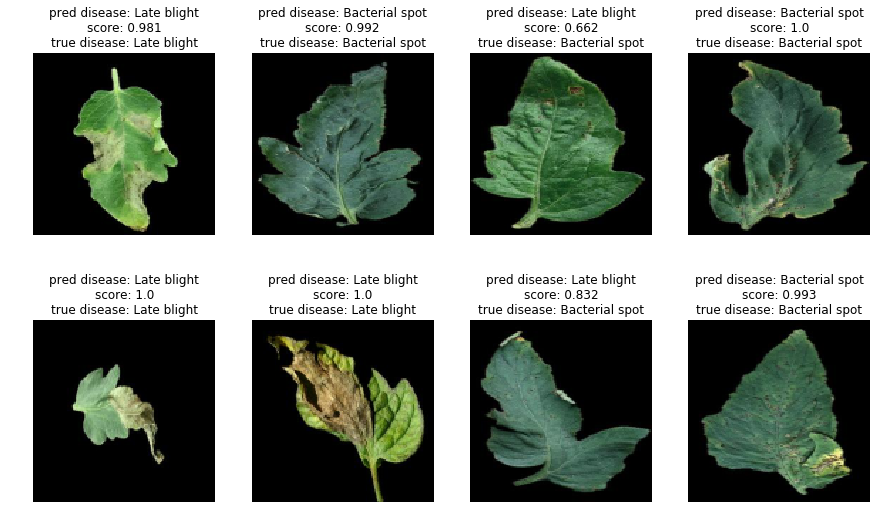

In [0]:
# inspect preditions
cols = 4
rows = 2
fig = plt.figure(figsize=(4 * cols - 1, 4 * rows + 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_test))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(X_test[random_index, :])
        
        pred_label = labels[int(y_pred_test_classes[random_index])]
        pred_proba = y_pred_test_max_probas[random_index]
        true_label = labels[int(y_test[random_index, 0])]
        
        ax.set_title("pred disease: {}\nscore: {:.3}\ntrue disease: {}".format(
               pred_label, pred_proba, true_label
        ))
plt.show()